<a href="https://colab.research.google.com/github/berry2971/senti-dict-petitions/blob/master/senti_dict_petitions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###과제 의의
* '불만'이라는 특정한 감성을 추출해내기란 쉽지 않다. 하지만 국민청원 게시판은 '불만, 원망, 간청'이라는 감성이 전적으로 드러나 있는 게시판이다. 이에 국민청원 게시판의 텍스트 분석을 통해 '불만'의 감성을 가진 단어들을 상당히 추출할 수 있을 것으로 보인다.

###과제 수행 방법
#####스크래핑
* Selenium을 사용하되, 별도의 코드로 실행함. (https://github.com/berry2971/scraper-petitions)

#####분석 대상
* 130641건의 국민청원을 대상으로 함.
* 보건복지: 6317
* 저출산/고령화대책: 960
* 행정: 6673
* 미래: 7589
* 안전/환경: 11460
* 성장동력: 3506
* 기타: 16800
* 일자리: 6884
* 외교/통일/국방: 9385
* 반려동물: 1481
* 교통/건축/국토: 8603
* 경제민주화: 6591
* 농산어촌: 603
* 육아/교육: 6833
*  정치개혁: 19518
* 인권/성평등: 10177
* 문화/예술/체육/언론: 7261

####형태소 분석
* 형태소 분석의 경우, SentencePiece 등 비지도 기반 형태소 분석기를 사용할 수도 있다. 하지만 국민청원의 경우 정부와 국민 사이의 공식적인 소통 창구로서 꽤나 정제된 언어로 작성될 뿐만 아니라, 만약 욕설 등 연구 가치가 있지만 OOV(Out Of Vocabulary)가 발생할 가능성이 높은 어휘이라 할지라도, 대부분 게시판 관리자에 의해 제거된다. 따라서 속도와 성능을 모두 고려하여 Mecab을 사용하여도 충분할 것이라 판단했다.
* Mecab은 일부 형태에 대해 용언과 어미를 붙여서 분석하기 때문에, lovit[1]이 공개한 soylemma 라이브러리를 통해 어간을 분석해낸다. 이는 okt 형태소 분석기의 POS 목록을 따르기 때문에 어미를 관형사형전성어미(ETM), 명사형전성어미(ETN) 등으로 구분할 수 없기에 어미를 누락시킬 수밖에 없다는 문제점을 지닌다. 그러나, 이러한 과정을 거치지 않으면 특정 품사의 출현 빈도를 분석해내는 과정에서, 실제 빈도와 분석 빈도 간의 격차가 커질 것임이 분명하다.

####KNU(케이앤유) 한국어 감성 사전(군산대학교)[2] 사용
* 박상민(군산대학교)·나철원(군산대학교)·최민성(군산대학교)·이다희(군산대학교)· 온병원(군산대학교)(2018), Bi-LSTM 기반의 한국어 감성사전 구축 방안
* KNU 한국어 감성 사전은 형용사뿐만 아니라 부사 등을 포함하고 있어 보다 풍부한 어휘를 지니고 있고, 도메인에서 비교적 자유롭다. 14843개의 어휘로 구성되어 있다.
* 기발표된 KNU 한국어 감성 사전의 부정 극성 단어를 기반으로 하여, 국민청원 게시물에서 Word2Vec을 통해 해당 단어와 유사한 맥락을 지니는 형용사(VA)/부사(MAG)/동사(VV)를 추출해 낸다.
* 일반명사(NNG), 고유명사(NNP)의 경우, 감성이 아니라, 해당 시기의 이슈와 트렌드를 반영하여 분석될 확률이 다분하여 추출 대상에서 제외한다.
* KNU 한국어 감성 사전의 각 단어들에 대해 추출이 진행되기 때문에 중복되는 단어가 발생하는데, 이 경우 가장 높은 코사인 유사도를 단어와 함께 저장한다.

[1] https://github.com/lovit

[2] https://github.com/park1200656/KnuSentiLex

In [0]:
##### Mount Google drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount = True)

In [0]:
##### Connect with db (raw text)
import sqlite3
con1 = sqlite3.connect('/content/gdrive/My Drive/senti/result_petitions.db')
cur1 = con1.cursor()

In [0]:
##### Connect with db (analyzed text)
con2 = sqlite3.connect('/content/gdrive/My Drive/senti/result_petitions_tag_with_mecab.db')
#con2.execute('CREATE TABLE analysis (TAGGED BLOB, CATEGORY TEXT, AGREES INTEGER)')

In [0]:
##### Install and import pos tagger: mecab
!pip install python-mecab-ko
import mecab
mecab = mecab.MeCab()

### Example
print("Example")
raw = "오늘은 지갑을 집에 두고 왔다."
print(raw)
print(mecab.pos(raw))

In [0]:
##### Install and import sentence divider: kss(Korean Sentence Splitter by 박상길)
!pip install kss
import kss

### Example
print("Example")
raw = "안녕하세요. 오늘은 날씨가 맑네요! 하늘도 푸르구요! 미세먼지만 없으면ㅠㅠ 좋을텐데ㅠㅠ"
print(raw)
print(kss.split_sentences(raw))

In [0]:
##### Install and import stem extractor: soylemma(by Lovit)
!pip install soylemma
from soylemma import Lemmatizer
lemmatizer = Lemmatizer()

### Example
print("Example")
print("안녕: {}".format(lemmatizer.lemmatize("안녕")))
print("예쁜: {}".format(lemmatizer.lemmatize("예쁜")))
print("간: {}".format(lemmatizer.lemmatize("간")))

In [0]:
########## SPENDS LONG TIME ##########
########## EXECUTE FIRST TIME ONLY ########## (See Line 33)
##### Pos tag and save it into database
import pickle
import re

count = 0

# Pos need to be saved
for row in cur1.execute("SELECT title, content, category, agrees FROM petitions"):
    tagged_sentences = []
    title_and_content = row[0]+"\n"+row[1]
    for sentence in kss.split_sentences(title_and_content):
        temp = []
        tag_res = mecab.pos(sentence)
        for t in tag_res:
            if re.search('\+', t[1]) == None:
                temp.append(t)
            else: # get stem from tagged tokens like ('하신', 'VV+ETM')
                lem = lemmatizer.analyze(t[0])
                if len(lem) != 0:
                    stem = lem[0] # (('예쁘', 'Adjective'), ('ㄴ', 'Eomi'))
                    if stem[0][1] == 'Verb':
                        temp.append((stem[0][0], "VV"))
                    elif stem[0][1] == 'Adjective':
                        temp.append((stem[0][0], "VA"))
        if temp:
            tagged_sentences.append(temp)
    
    # Insert pickled data into database
    data = tagged_sentences
    pdata = pickle.dumps(data)
    # con2.execute('INSERT INTO analysis (TAGGED, CATEGORY, AGREES) VALUES (?, ?, ?)', [pdata, row[2], row[3]])

    # Check progress and Commit database
    count += 1
    if count % 5000 == 0:
        print(count)
        con2.commit()

con2.commit()

In [0]:
def parse_token(token):
    word = re.search("(.*)/(.*)", token).group(1)
    pos = re.search("(.*)/(.*)", token).group(2)
    return (word, pos)

def parse_tagged_word(word):
    lst = word.split(sep = "/")
    return (lst[0], lst[1])

In [0]:
##### Load database
import pickle

con3 = con2
cur3 = con3.cursor()

data_ctg = dict()
categories = ['보건복지', '저출산/고령화대책', '행정', '미래', '안전/환경', '성장동력', '기타', '일자리', '외교/통일/국방', '반려동물', '교통/건축/국토', '경제민주화', '농산어촌', '육아/교육', '정치개혁', '인권/성평등', '문화/예술/체육/언론']
count_doc_categories = []
for i in range(len(categories)):
    count_doc_categories.append(0)
for c in categories:
    data_ctg.update({c:[]})

count = 0
for docs in cur3.execute("SELECT * FROM analysis"):
    # Check progress
    count += 1
    if count % 15000 == 0:
        print(count, end='...')
        print(int(count/130641*100), end='')
        print("%")
    if count == 130641:
        print("130641...100%")

    content = pickle.loads(docs[0])
    category = docs[1]
    agrees = docs[2]

    # Count numbers
    count_doc_categories[categories.index(category)] += 1

    # Convert (안녕, IC) to 안녕/IC
    for sentence in content:
        for i in range(len(sentence)):
            word = sentence[i][0]
            pos = sentence[i][1]
            tagged_word = word+"/"+pos
            sentence[i] = tagged_word
            
    data_ctg[category].append((content, agrees))

print()
for c in categories:
    print("{c}: {num}".format(c=c, num=count_doc_categories[categories.index(c)]))

In [0]:
##### Preprocess data
data_ctg_sentences = dict() # {'보건복지':[['먼저/MAG','가/VV', '아/EF'], ['오늘/NNG', '도/JX']], '일자리':[['성공/NNG', '하/XSV', '았/EP', '나/EF'], ['글쎄/IC']], ...}
categories = ['보건복지', '저출산/고령화대책', '행정', '미래', '안전/환경', '성장동력', '기타', '일자리', '외교/통일/국방', '반려동물', '교통/건축/국토', '경제민주화', '농산어촌', '육아/교육', '정치개혁', '인권/성평등', '문화/예술/체육/언론']
for c in categories:
    data_ctg_sentences.update({c:[]})

for key in data_ctg.keys():
    sentences = []
    for d in data_ctg[key]:
        for sentence in d[0]:
            sentences.append(sentence)
    data_ctg_sentences[key].extend(sentences)

In [0]:
iter = 50
window = 3

In [0]:
########## SPENDS LONG TIME ##########
########## EXECUTE FIRST TIME ONLY ##########
##### Model without considering category
whole_sentence = []

for petition in list(data_ctg_sentences.values()): # list(data_ctg_sentences.values())[0][0]: sentence
    for sentence in petition:
        whole_sentence.append(sentence)

from gensim.models import Word2Vec
model_whole = Word2Vec(whole_sentence, size=300, window=window, min_count=5, workers=4, sg=1, iter=iter, sample=0.00001)

In [0]:
##### Save trained model
with open('/content/gdrive/My Drive/senti/models/model_whole_iter{iter}_window{window}.bin'.format(iter=iter, window=window), 'wb') as f:
    pickle.dump(model_whole, f)

In [0]:
##### Load trained model
with open('/content/gdrive/My Drive/senti/models/model_whole_iter{iter}_window{window}.bin'.format(iter=iter, window=window), 'rb') as f:
    model_whole = pickle.load(f)

In [0]:
########## SPENDS LONG TIME ##########
########## EXECUTE FIRST TIME ONLY ##########
##### Model with considering category
from gensim.models import Word2Vec

models = []

count = 0
for v in data_ctg_sentences.values():
    count += 1
    print("{cntt}/17".format(cntt=count))
    models.append(Word2Vec(v, size=300, window=window, min_count=5, workers=4, sg=1, iter=iter, sample=0.00001))

In [0]:
##### Save trained models
import re
for i in range(len(models)):
    ctg_name = categories[i]
    if re.search("/", ctg_name) != None:
        ctg_name = re.sub("/", "+", ctg_name)

    with open('/content/gdrive/My Drive/senti/models/model_{pos}_iter{iter}_window{window}.bin'.format(pos=ctg_name, iter=iter, window=window), 'wb') as f:
        pickle.dump(models[i], f)

In [0]:
##### Load trained models
import re
models = []
for i in range(len(categories)):
    ctg_name = categories[i]
    if re.search("/", ctg_name) != None:
        ctg_name = re.sub("/", "+", ctg_name)
    with open('/content/gdrive/My Drive/senti/models/model_{pos}_iter{iter}_window{window}.bin'.format(pos=ctg_name, iter=iter, window=window), 'rb') as f:
        models.append(pickle.load(f))

Visualize

In [0]:
##### Install Nanum Fonts
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [0]:
obj_model = model_whole # obj_model = models_whole, models[n]
obj_pos = "VA" # obj_pos = "VV", "VA", "MAG"

##### t-SNE: t-Stochastic Neighbor Embedding
import re
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

matplotlib.rcParams["axes.unicode_minus"] = False

vocab = [v for v in list(obj_model.wv.vocab) if parse_tagged_word(v)[1] == obj_pos]
#vocab = obj_model.wv.vocab
X = obj_model[vocab]

tsne = TSNE(n_components = 2)
X_tsne = tsne.fit_transform(X)

##### Show data frame
import pandas as pd
df = pd.DataFrame(X_tsne, index = vocab, columns = ["x", "y"])
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


,x,y
하/VA,0.545490,2.841342
바쁘/VA,2.145220,2.717964
이/VA,0.531748,2.823709
힘들/VA,1.601089,2.518456
많/VA,1.065648,3.219760


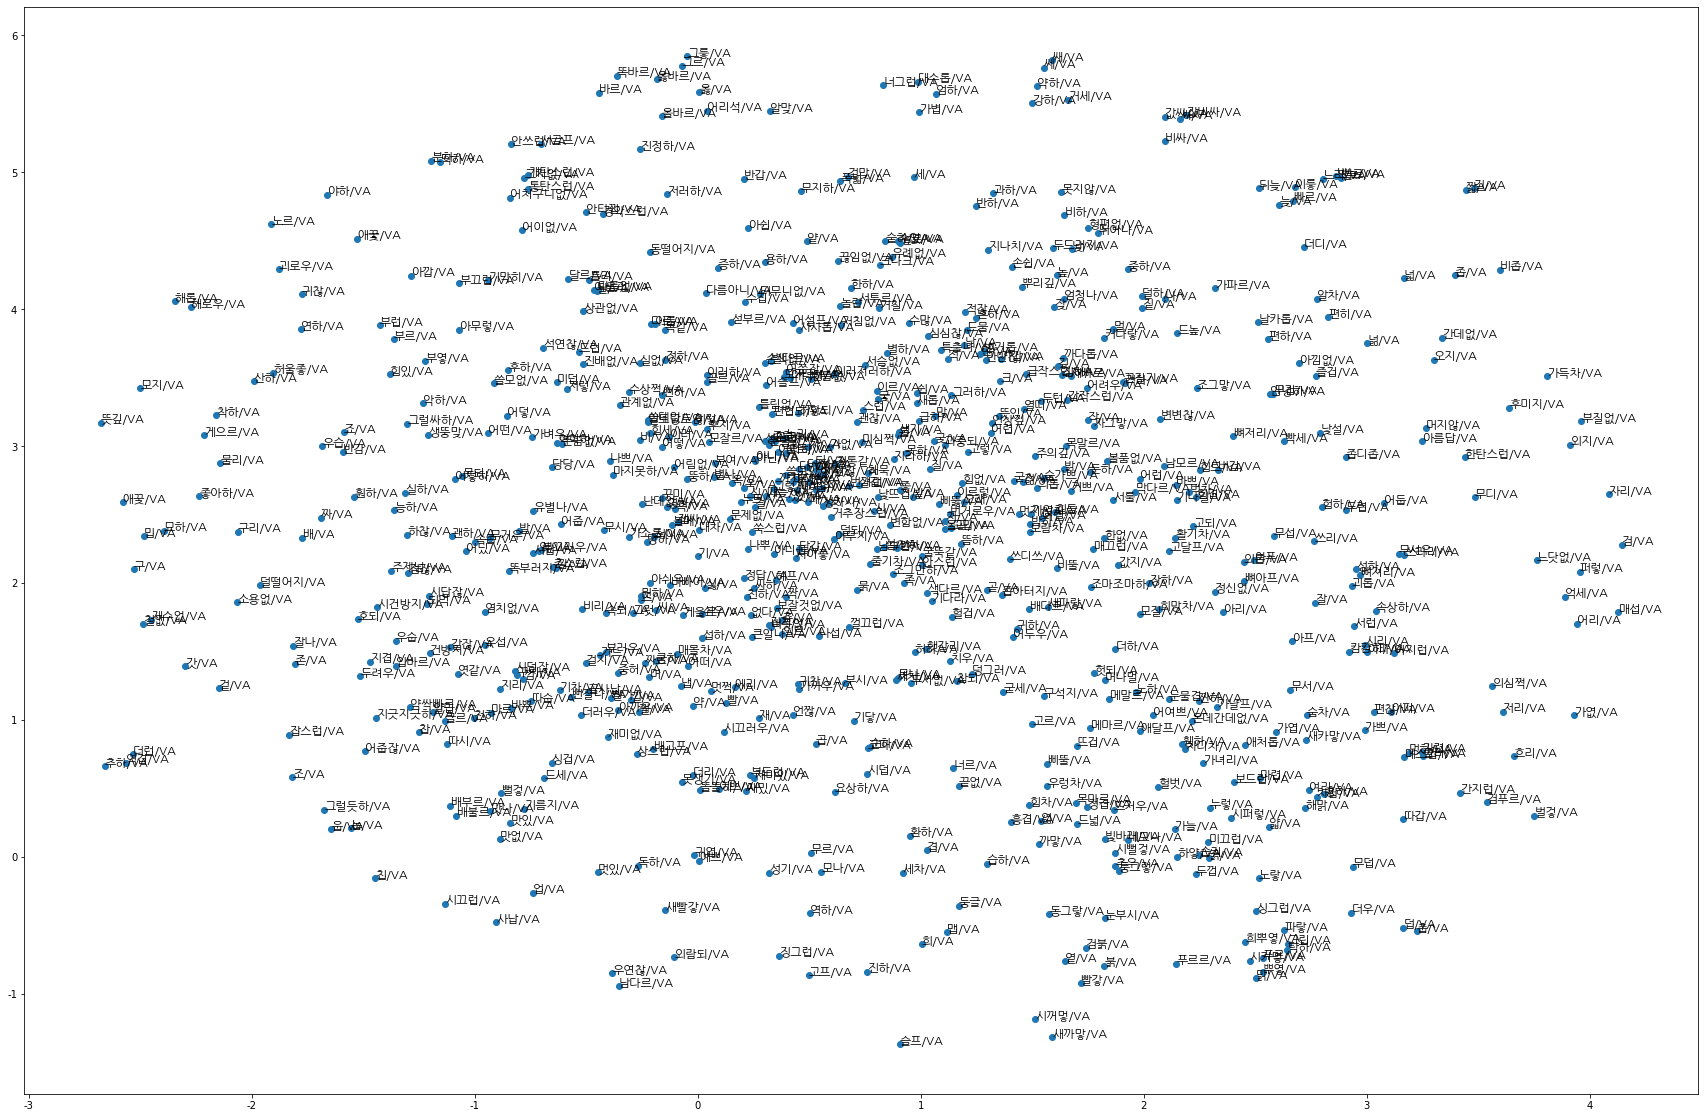

In [0]:
##### Draw figure
%matplotlib inline

fig = plt.figure()
fig.set_size_inches(30,20)

ax = fig.add_subplot(1, 1, 1)
ax.scatter(df["x"], df["y"])

prop = fm.FontProperties(fname = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf")
for word, pos in list(df.iterrows()):
  ax.annotate(word, pos, fontsize = 12, fontproperties = prop)

plt.show()

In [24]:
##### Read KNU neg_pol_word
knu_negv_words = set()
with open('/content/gdrive/My Drive/senti/neg_pol_word.txt', 'r', encoding = 'utf8') as f:
    knu_negv_file = f.readlines()

one_ej = 0
for i in range(len(knu_negv_file)):
    knu_negv_file[i] = knu_negv_file[i].strip()
    item = knu_negv_file[i]
    if (len(item.split(sep=' ')) == 1): # apply for single ej item only
        one_ej += 1
        pos_res = mecab.pos(item)
        tagged_item = pos_res[0][0]+"/"+pos_res[0][1]
        knu_negv_words.add(tagged_item)
knu_negv_words = list(knu_negv_words) # ['방탕/NNG', '^-^;;/SY', '결핍/NNG', '짖궂/VA', '맛없/VA']
print(one_ej)

4187


In [25]:
##### Get word set
final_word_dict = dict()
final_word_dict_keyset = set()

min_cos_sim = 0.5

for i in range(len(models)):
    print("model_{name}".format(name=categories[i]))
    cur_model = models[i]
    cur_negv_words = []
    for token in knu_negv_words:
        if parse_tagged_word(token)[1] not in ['MAG', 'VA', 'VV']:
            continue
        try:
            cur_sims = cur_model.wv.most_similar(token, topn = 5000)
            for w in cur_sims:
                if parse_tagged_word(w[0])[1] == parse_tagged_word(token)[1] and w[1] >= min_cos_sim:
                    cur_negv_words.append(w)
                    if w[0] not in final_word_dict_keyset:
                        final_word_dict.update({w[0]: 0})
                    final_word_dict_keyset.add(w[0]) # final result
                    if final_word_dict[w[0]] < w[1]:
                        final_word_dict.update({w[0]: w[1]})
        except:
            continue

    wordset = set()
    for w in cur_negv_words:
        wordset.add(w[0])
    
    worddict = dict()
    for w in wordset:
        worddict[w] = []
    
    for w in cur_negv_words:
        worddict[w[0]].append(w[1])
    
    for key in worddict.keys():
        worddict[key] = max(worddict[key])
    
    print(list(worddict.items())[:10])
    print(len(list(worddict.items())))

# final_word_dict
print(list(final_word_dict.items())[:10])
print(len(list(final_word_dict.items())))

model_보건복지


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('유하/VV', 0.5009228587150574), ('꺼지/VV', 0.5717027187347412), ('풍기/VV', 0.7520176768302917), ('키우/VV', 0.5307872295379639), ('비키/VV', 0.5315654277801514), ('흘러가/VV', 0.5101516842842102), ('띵/MAG', 0.6496580243110657), ('휩싸/VV', 0.5495595335960388), ('왈/MAG', 0.5166242122650146), ('졸/VV', 0.5025303363800049)]
653
model_저출산/고령화대책
[('크/VA', 0.9720612168312073), ('너무너무/MAG', 0.6952846050262451), ('키우/VV', 0.9139087200164795), ('충분히/MAG', 0.9800385236740112), ('옳/VA', 0.7029789686203003), ('위하/VV', 0.8566464185714722), ('이제/MAG', 0.7776598930358887), ('앞당기/VV', 0.9785116910934448), ('놓/VV', 0.9776130318641663), ('겪/VV', 0.9832239151000977)]
736
model_행정
[('풍기/VV', 0.620028018951416), ('싫어하/VV', 0.51789391040802), ('깜짝/MAG', 0.5276461839675903), ('흘러가/VV', 0.513985276222229), ('비키/VV', 0.5091574192047119), ('휩싸/VV', 0.5921941995620728), ('따라다니/VV', 0.5513201951980591), ('들이받/VV', 0.6345757246017456), ('두서없이/MAG', 0.5782804489135742), ('큰소리치/VV', 0.5335674285888672)]
456
model_미래
[('퍼트리/VV',

In [26]:
##### Create final result
import pandas
from pprint import pprint
final_res = list(final_word_dict.items())
final_res = [x for x in sorted(final_res, key=lambda x: x[1], reverse=True)]

pprint(final_res)

df = pandas.DataFrame(data = final_res)

df.to_csv("/content/gdrive/My Drive/senti/result/final_result.csv", mode = 'w', encoding = 'utf8', header = False, index = False)

[('넘어가/VV', 0.9989886283874512),
 ('치우/VV', 0.9989355802536011),
 ('안/VV', 0.998897135257721),
 ('흔하/VA', 0.9987937808036804),
 ('제발/MAG', 0.9987806677818298),
 ('치/VV', 0.9987481832504272),
 ('울리/VV', 0.9987307786941528),
 ('내몰/VV', 0.9986920952796936),
 ('계시/VV', 0.9986498355865479),
 ('저지르/VV', 0.9986412525177002),
 ('움직이/VV', 0.9986332654953003),
 ('지내/VV', 0.9986273646354675),
 ('가끔/MAG', 0.9985555410385132),
 ('이러/VV', 0.9985347390174866),
 ('고치/VV', 0.9985238313674927),
 ('바쁘/VA', 0.9985224008560181),
 ('싫/VA', 0.9985224008560181),
 ('견디/VV', 0.9984930157661438),
 ('조그맣/VA', 0.9984804391860962),
 ('반기/VV', 0.9984554648399353),
 ('편하/VA', 0.9984502792358398),
 ('배/VV', 0.998432993888855),
 ('무섭/VA', 0.9984263181686401),
 ('부끄럽/VA', 0.9984263181686401),
 ('어차피/MAG', 0.9983710646629333),
 ('전하/VV', 0.9983665943145752),
 ('무너지/VV', 0.9983618259429932),
 ('피하/VV', 0.9983617067337036),
 ('어리/VV', 0.9983589053153992),
 ('맑/VA', 0.9983539581298828),
 ('옳/VA', 0.9983466267585754),
 ('괜찮/